# Trends and Averages for Summer Months for MACAv2-CMIP5

## Imports

In [32]:
import xarray as xr
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
import dask
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import sys

## Functions

## Inputs

In [8]:
file_base = "/storage/group/pches/default/public/MACA-CMIP5/raw/macav2metdata_"
models = ["BNU-ESM", "CNRM-CM5", "CSIRO-Mk3-6-0", "CanESM2", "GFDL-ESM2G", "GFDL-ESM2M", "HadGEM2-CC365", "HadGEM2-ES365", "IPSL-CM5A-LR",
         "IPSL-CM5A-MR", "IPSL-CM5B-LR", "MIROC-ESM-CHEM", "MIROC-ESM", "MIROC5", "bcc-csm1-1-m", "MRI-CGCM3", "bcc-csm1-1", "inmcm4"]
fwi_input_fields = ["rhsmin", "tasmax", "pr"]
possible_scenario_str = ['rcp45', 'historical']
start_year, end_year = 1979, 2025
lon_max = -114.016667
lon_min = -124.766667
lat_min = 32.025
lat_max = 50
start_day = 152
end_day = 304

In [9]:
def model_trend(model_i):
    '''
    given some model name, returns the climatology of the windspeed for MACAv2 CMIP5 
    inputs
    - model_i
    outputs
    - single xarray trendmap for model_i for var_i?
    '''
    for input_field in fwi_input_fields[:1]:
        input_field_paths = sorted(glob.glob(f'{file_base}{input_field}_{model_i}*'))
        correct_paths = []
        for path_i in input_field_paths:
            start_year_i = int(path_i.split("_")[-4])
            end_year_i = int(path_i.split("_")[-3])
            if ((start_year_i >= start_year) and (end_year_i <= end_year)) or (end_year_i == start_year) or (start_year_i == end_year):
                if path_i.split("_")[-5] in possible_scenario_str:
                    correct_paths.append(path_i)
                    
        # now we can do something with the "correct" correct_paths list 
        ds_model_i = xr.open_mfdataset(correct_paths, chunks='auto')
        ds_model_i["lon"] = np.where(ds_model_i["lon"] > 180, ds_model_i["lon"] - 360, ds_model_i["lon"])
        ds_model_i = ds_model_i.where((ds_model_i.lon >= lon_min) & (ds_model_i.lon <= lon_max) & 
                                        (ds_model_i.lat >= lat_min) & (ds_model_i.lat <= lat_max), drop=True)
        ds_model_i = ds_model_i.sel(time=~((ds_model_i.time.dt.month == 2) & (ds_model_i.time.dt.day == 29)))
        
        ds_model_i = ds_model_i.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
        mask = (ds_model_i["time"].dt.dayofyear >= start_day) & (ds_model_i["time"].dt.dayofyear <= end_day)
        ds_model_i = ds_model_i.where(mask, drop=True)
        ds_annual = ds_model_i.groupby("time.year").mean(dim="time")
        
        key = list(ds_annual.keys())[0]
        yearly_mean = ds_annual.mean(dim='year')
        poly_coeffs = ds_annual[key].polyfit(dim="year", deg=1)
        poly_coeffs_key = list(poly_coeffs.keys())[0]
        poly_coeffs = poly_coeffs.rename({poly_coeffs_key:key})
        poly_fits = xr.polyval(coord=ds_annual["year"], coeffs=poly_coeffs)
        trendline =  poly_coeffs.sel(degree=1)[key]
        return trendline

## dask

In [10]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="open",
    cores=1,
    memory="100GiB",
    walltime="02:00:00",
    processes=1
)

cluster.scale(jobs=8)

from dask.distributed import Client

client = Client(cluster)

Task exception was never retrieved
future: <Task finished name='Task-25224' coro=<Client._gather.<locals>.wait() done, defined at /storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit


In [13]:
client

<Client: 'tcp://146.186.150.12:32801' processes=8 threads=8, memory=800.00 GiB>

In [14]:
results = []
for model_i in models:
    out = dask.delayed(model_trend)(model_i)
    results.append(out)

In [15]:
results_compute = dask.compute(*results)

In [27]:
combined = xr.concat(results_compute, dim="ensemble")
ensemble_mean = combined.mean(dim="ensemble")
ensemble_mean.load()

/storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 16.72 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.DataArray 'relative_humidity' (lat: 417, lon: 258)> Size: 861kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(417, 258))
Coordinates:
    degree   int64 8B 1
  * lat      (lat) float64 3kB 32.06 32.1 32.15 32.19 ... 49.27 49.31 49.35 49.4
  * lon      (lon) float64 2kB -124.7 -124.7 -124.6 ... -114.1 -114.1 -114.0

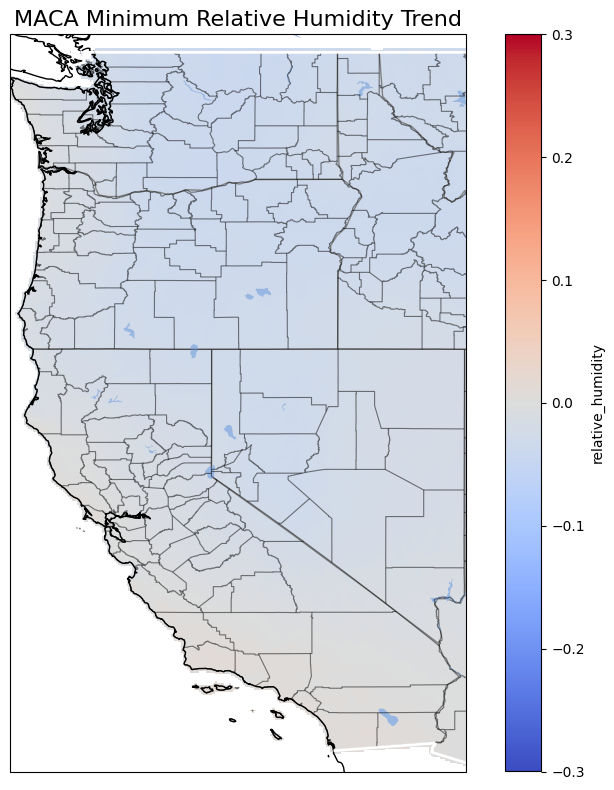

In [38]:
reader = shpreader.Reader('/storage/work/cta5244/2024_FWI_CMIP5_Ensemble_Avila/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')


cmap='coolwarm'
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ensemble_mean.plot(ax=ax,cmap=cmap, vmin=-.3, vmax=.3)

ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')


plt.title(f'MACA Minimum Relative Humidity Trend', fontsize=16)
fig.tight_layout()
#plt.savefig(f'/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/revision_notebooks/revision_figures/2_MACA_FWI_Inputs_rhmin_1979_2022_Trend')